# Convolutional neural network for classifying Root data fits.


Here, we define, train, and save new convolutional models as well as some 
simple model evaluation. We define hyper-parameters, number of layers, and 
training and testing datasets. 

#### Load necessary packages

In [1]:
# Load some packages

# Keras packages for network
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, Conv2D, Flatten
from keras.models import Model
from keras.optimizers import Adam, SGD
# For saving model
from keras.models import model_from_json

# Some items for plotting and drawing
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from PIL import Image
from scipy import misc
import matplotlib.pyplot as plt

# Need numpy
import numpy as np
import nn_utils as utils

%matplotlib inline

Using TensorFlow backend.


#### Load root fit data from file

In [2]:
# Load dataset
x, y = utils.load_dataset_mysql(im_dir="train", log=False)
x_dev, y_dev = utils.load_dataset_mysql(im_dir="dev", log=False)

# Grab dimensions of picture
(m, h, w, c) = x.shape
m_dev = x_dev.shape[0]
input_shape = h, w, c

# Print dimensions
print("(m, height, width, channels): (" + str(m) + ", " + str(h) + ", " + str(w) + ", " + str(c) + ")")
print("m_dev: " + str(m_dev))


(m, height, width, channels): (1396, 236, 348, 3)
m_dev: 129


label: bad
label: [0]


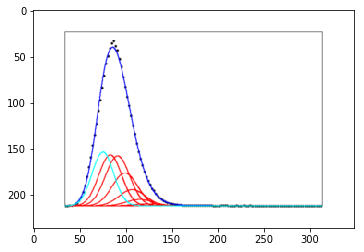

In [3]:
# Print an image
index = 77
this_image = x[index]
if y[index] == 1:
    print("label: good")
else:
    print("label: bad")
print("label: " + str(y[index]))
plt.imshow(np.uint8(utils.get_printable_image(this_image)))

## Define and Train multi-layer ConvNet with 2 fully connected layers plus output layer

For the convolutional layer, we will scan over our images with a certain stride and a certain kernal size. 
Each individual scan represents a single neuron in the next layer. Since each scan connects to kernal size squared
neurons below it, convolutions reduce the number of degrees of freedom. Hopefully, through learning the right filters,
we can preserve the important information as we reduce it in size.

Once the image has gone through the convolutional layers (and therefore has been reduced to its features vector), we
can send the resulting vector into some old-fashioned fully-connected layers, and finally into a logistic regression unit.

##### Define hyperparameters

In [31]:
# Initialize
filters = []
kernels = []
strides = []
pools = []
dropouts = []

# Conv1
filters.append(16)
kernels.append(7)
strides.append(2)
pools.append(1)
dropouts.append(0.4)

# Conv2
filters.append(64)
kernels.append(5)
strides.append(3)
pools.append(2)
dropouts.append(0.4)

# Conv3
filters.append(128)
kernels.append(3)
strides.append(1)
pools.append(2)
dropouts.append(0.3)

# Define dense (fully-connected) layer sizes
fc1 = 20
fc2 = 20

##### Define keras layers (model)

In [36]:
# Define input layer (RGB image matrix)
X = Input(shape=input_shape, name='Input')

# Initialize activation as input
a = X
# Loop through all convolutional layers
for i in range(len(filters)):
    # Perform convolution
    a = Conv2D(filters=filters[i], kernel_size=(kernels[i], kernels[i]), strides=(strides[i], strides[i]), name=('conv' + str(i)))(a)
    # Normalize
    a = BatchNormalization(axis=3, name=('bn' + str(i)))(a)
    # Activate
    a = Activation('relu', name=('a' + str(i)))(a)
    # Max-pool
    a = MaxPooling2D((pools[i], pools[i]), name=('max_pool' + str(i)))(a)
    # Dropout
    a = Dropout(rate=dropouts[i])(a)

# Flatten output of convNet
a = Flatten()(a)
# Define first fully connected layer
a = Dense(units=fc1, activation='relu', name='fc0')(a)
# Use some dropout here for regularization
a = Dropout(rate=0.2)(a)
# Define second fully connected layer
a = Dense(units=fc2, activation='relu', name='fc1')(a)
# Define output layer 
a = Dense(units=1, activation='sigmoid', name='sigmoid')(a)

# Make the model
model = Model(inputs=X, outputs=a)

##### Define optimizer, loss, and metrics. Compile model.

In [37]:
# Define optimizer
#opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.001)
opt = SGD(lr=1.0, decay=1e-6, momentum=0.9, nesterov=True)
# Define loss
loss = 'mean_squared_error'
# Define metrics to use
metrics=['acc']
# Compile model
model.compile(loss=loss, optimizer='sgd', metrics=metrics)
# Print summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 236, 348, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 115, 171, 16)      2368      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 115, 171, 16)      64        
_________________________________________________________________
a0 (Activation)              (None, 115, 171, 16)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 115, 171, 16)      0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 115, 171, 16)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 37, 56, 64)        25664     
__________

##### Fit the model to the data (train)

In [40]:
histories = []
for i in range(10):
    # Now, fit the model to the data
    history = model.fit(x, y, validation_data=(x_dev, y_dev), epochs=200, batch_size=256)
    histories.append(history)
    # serialize model to JSON
    model_json = model.to_json()
    with open("trained/conv_model_temp_" + str(i) + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("trained/conv_model_temp_" + str(i) + ".h5")
    print("Saved model to disk")
    

Train on 1396 samples, validate on 129 samples
Epoch 1/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0990 - acc: 0.8696 - val_loss: 0.1464 - val_acc: 0.8140
Epoch 2/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0985 - acc: 0.8675 - val_loss: 0.1339 - val_acc: 0.8372
Epoch 3/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1000 - acc: 0.8660 - val_loss: 0.1391 - val_acc: 0.8527
Epoch 4/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0975 - acc: 0.8689 - val_loss: 0.1420 - val_acc: 0.8217
Epoch 5/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.1004 - acc: 0.8632 - val_loss: 0.1348 - val_acc: 0.8372
Epoch 6/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0981 - acc: 0.8682 - val_loss: 0.1329 - val_acc: 0.8372
Epoch 7/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0987 - acc: 0.8632 - val_loss: 0.1308 - val_acc: 0.8450
Epoch 8/

Epoch 61/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0915 - acc: 0.8725 - val_loss: 0.1395 - val_acc: 0.8062
Epoch 62/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0878 - acc: 0.8782 - val_loss: 0.1340 - val_acc: 0.8217
Epoch 63/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0921 - acc: 0.8746 - val_loss: 0.1353 - val_acc: 0.8295
Epoch 64/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0942 - acc: 0.8725 - val_loss: 0.1343 - val_acc: 0.8140
Epoch 65/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0949 - acc: 0.8732 - val_loss: 0.1331 - val_acc: 0.8217
Epoch 66/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0968 - acc: 0.8711 - val_loss: 0.1353 - val_acc: 0.8372
Epoch 67/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0944 - acc: 0.8711 - val_loss: 0.1378 - val_acc: 0.8217
Epoch 68/200
1396/1396 [========================

1396/1396 [==============================] - 4s 3ms/step - loss: 0.0877 - acc: 0.8832 - val_loss: 0.1304 - val_acc: 0.8372
Epoch 122/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0882 - acc: 0.8854 - val_loss: 0.1282 - val_acc: 0.8295
Epoch 123/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0871 - acc: 0.8761 - val_loss: 0.1286 - val_acc: 0.8372
Epoch 124/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0882 - acc: 0.8782 - val_loss: 0.1343 - val_acc: 0.8062
Epoch 125/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0911 - acc: 0.8804 - val_loss: 0.1336 - val_acc: 0.8062
Epoch 126/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0919 - acc: 0.8754 - val_loss: 0.1369 - val_acc: 0.8062
Epoch 127/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0878 - acc: 0.8875 - val_loss: 0.1312 - val_acc: 0.8295
Epoch 128/200
1396/1396 [==============================

Epoch 181/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0882 - acc: 0.8832 - val_loss: 0.1336 - val_acc: 0.8295
Epoch 182/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0908 - acc: 0.8811 - val_loss: 0.1288 - val_acc: 0.8372
Epoch 183/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0884 - acc: 0.8761 - val_loss: 0.1332 - val_acc: 0.8217
Epoch 184/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0817 - acc: 0.8883 - val_loss: 0.1263 - val_acc: 0.8295
Epoch 185/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0868 - acc: 0.8811 - val_loss: 0.1325 - val_acc: 0.8372
Epoch 186/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0860 - acc: 0.8897 - val_loss: 0.1309 - val_acc: 0.8295
Epoch 187/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0845 - acc: 0.8797 - val_loss: 0.1305 - val_acc: 0.8295
Epoch 188/200
1396/1396 [================

1396/1396 [==============================] - 4s 3ms/step - loss: 0.0807 - acc: 0.8933 - val_loss: 0.1229 - val_acc: 0.8372
Epoch 41/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0793 - acc: 0.8933 - val_loss: 0.1275 - val_acc: 0.8372
Epoch 42/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0826 - acc: 0.8875 - val_loss: 0.1235 - val_acc: 0.8372
Epoch 43/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0840 - acc: 0.8854 - val_loss: 0.1179 - val_acc: 0.8527
Epoch 44/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0822 - acc: 0.8832 - val_loss: 0.1241 - val_acc: 0.8450
Epoch 45/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0788 - acc: 0.8911 - val_loss: 0.1288 - val_acc: 0.7984
Epoch 46/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0764 - acc: 0.9004 - val_loss: 0.1332 - val_acc: 0.8062
Epoch 47/200
1396/1396 [==============================] - 4s 

1396/1396 [==============================] - 4s 3ms/step - loss: 0.0782 - acc: 0.8854 - val_loss: 0.1322 - val_acc: 0.7907
Epoch 101/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0767 - acc: 0.8983 - val_loss: 0.1204 - val_acc: 0.8295
Epoch 102/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0813 - acc: 0.8933 - val_loss: 0.1259 - val_acc: 0.8217
Epoch 103/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0797 - acc: 0.8904 - val_loss: 0.1283 - val_acc: 0.8140
Epoch 104/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0755 - acc: 0.8890 - val_loss: 0.1289 - val_acc: 0.8295
Epoch 105/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0774 - acc: 0.8897 - val_loss: 0.1235 - val_acc: 0.8295
Epoch 106/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0808 - acc: 0.8875 - val_loss: 0.1165 - val_acc: 0.8450
Epoch 107/200
1396/1396 [==============================

Epoch 160/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0719 - acc: 0.9054 - val_loss: 0.1267 - val_acc: 0.8062
Epoch 161/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0788 - acc: 0.8861 - val_loss: 0.1325 - val_acc: 0.7984
Epoch 162/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0741 - acc: 0.9011 - val_loss: 0.1250 - val_acc: 0.8217
Epoch 163/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0702 - acc: 0.9083 - val_loss: 0.1251 - val_acc: 0.8062
Epoch 164/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0726 - acc: 0.9033 - val_loss: 0.1303 - val_acc: 0.7984
Epoch 165/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0767 - acc: 0.8976 - val_loss: 0.1295 - val_acc: 0.8140
Epoch 166/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0795 - acc: 0.8868 - val_loss: 0.1302 - val_acc: 0.7984
Epoch 167/200
1396/1396 [================

1396/1396 [==============================] - 4s 3ms/step - loss: 0.0734 - acc: 0.9011 - val_loss: 0.1260 - val_acc: 0.7984
Epoch 20/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0712 - acc: 0.9019 - val_loss: 0.1195 - val_acc: 0.8217
Epoch 21/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0711 - acc: 0.9119 - val_loss: 0.1221 - val_acc: 0.8140
Epoch 22/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0697 - acc: 0.9097 - val_loss: 0.1310 - val_acc: 0.8062
Epoch 23/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0751 - acc: 0.8968 - val_loss: 0.1346 - val_acc: 0.8062
Epoch 24/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0712 - acc: 0.9040 - val_loss: 0.1246 - val_acc: 0.8062
Epoch 25/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0773 - acc: 0.8947 - val_loss: 0.1227 - val_acc: 0.8140
Epoch 26/200
1396/1396 [==============================] - 4s 

1396/1396 [==============================] - 4s 3ms/step - loss: 0.0676 - acc: 0.9076 - val_loss: 0.1195 - val_acc: 0.8217
Epoch 80/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0714 - acc: 0.9011 - val_loss: 0.1214 - val_acc: 0.8140
Epoch 81/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0699 - acc: 0.9040 - val_loss: 0.1249 - val_acc: 0.7984
Epoch 82/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0679 - acc: 0.9083 - val_loss: 0.1172 - val_acc: 0.8140
Epoch 83/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0656 - acc: 0.9140 - val_loss: 0.1157 - val_acc: 0.8295
Epoch 84/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0709 - acc: 0.8954 - val_loss: 0.1235 - val_acc: 0.8140
Epoch 85/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0661 - acc: 0.9140 - val_loss: 0.1115 - val_acc: 0.8372
Epoch 86/200
1396/1396 [==============================] - 4s 

1396/1396 [==============================] - 4s 3ms/step - loss: 0.0665 - acc: 0.9076 - val_loss: 0.1196 - val_acc: 0.8295
Epoch 140/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0654 - acc: 0.9105 - val_loss: 0.1162 - val_acc: 0.8372
Epoch 141/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0657 - acc: 0.9176 - val_loss: 0.1134 - val_acc: 0.8217
Epoch 142/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0628 - acc: 0.9169 - val_loss: 0.1135 - val_acc: 0.8605
Epoch 143/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0609 - acc: 0.9183 - val_loss: 0.1090 - val_acc: 0.8527
Epoch 144/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0631 - acc: 0.9198 - val_loss: 0.1119 - val_acc: 0.8605
Epoch 145/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0604 - acc: 0.9241 - val_loss: 0.1159 - val_acc: 0.8527
Epoch 146/200
1396/1396 [==============================

Epoch 199/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0672 - acc: 0.9119 - val_loss: 0.1144 - val_acc: 0.8605
Epoch 200/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0638 - acc: 0.9162 - val_loss: 0.1042 - val_acc: 0.8527
Saved model to disk
Train on 1396 samples, validate on 129 samples
Epoch 1/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0651 - acc: 0.9112 - val_loss: 0.1109 - val_acc: 0.8605
Epoch 2/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0640 - acc: 0.9126 - val_loss: 0.1127 - val_acc: 0.8605
Epoch 3/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0618 - acc: 0.9162 - val_loss: 0.1125 - val_acc: 0.8527
Epoch 4/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0640 - acc: 0.9183 - val_loss: 0.1113 - val_acc: 0.8605
Epoch 5/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0609 - acc: 0.9176 - val_loss: 0.1132 - 

Epoch 59/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0635 - acc: 0.9176 - val_loss: 0.1077 - val_acc: 0.8605
Epoch 60/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0650 - acc: 0.9148 - val_loss: 0.1040 - val_acc: 0.8527
Epoch 61/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0568 - acc: 0.9248 - val_loss: 0.1114 - val_acc: 0.8605
Epoch 62/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0624 - acc: 0.9248 - val_loss: 0.1139 - val_acc: 0.8605
Epoch 63/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0614 - acc: 0.9212 - val_loss: 0.1118 - val_acc: 0.8527
Epoch 64/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0587 - acc: 0.9277 - val_loss: 0.1081 - val_acc: 0.8527
Epoch 65/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0610 - acc: 0.9226 - val_loss: 0.1093 - val_acc: 0.8527
Epoch 66/200
1396/1396 [========================

1396/1396 [==============================] - 4s 3ms/step - loss: 0.0602 - acc: 0.9226 - val_loss: 0.1114 - val_acc: 0.8527
Epoch 120/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0588 - acc: 0.9284 - val_loss: 0.1115 - val_acc: 0.8527
Epoch 121/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0594 - acc: 0.9234 - val_loss: 0.1122 - val_acc: 0.8527
Epoch 122/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0561 - acc: 0.9248 - val_loss: 0.1170 - val_acc: 0.8450
Epoch 123/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0539 - acc: 0.9291 - val_loss: 0.1144 - val_acc: 0.8605
Epoch 124/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0601 - acc: 0.9183 - val_loss: 0.1149 - val_acc: 0.8527
Epoch 125/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0621 - acc: 0.9198 - val_loss: 0.1071 - val_acc: 0.8527
Epoch 126/200
1396/1396 [==============================

Epoch 179/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0547 - acc: 0.9312 - val_loss: 0.1059 - val_acc: 0.8760
Epoch 180/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0607 - acc: 0.9155 - val_loss: 0.1055 - val_acc: 0.8527
Epoch 181/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0602 - acc: 0.9191 - val_loss: 0.1065 - val_acc: 0.8760
Epoch 182/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0596 - acc: 0.9205 - val_loss: 0.1015 - val_acc: 0.8682
Epoch 183/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0609 - acc: 0.9155 - val_loss: 0.1052 - val_acc: 0.8760
Epoch 184/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0595 - acc: 0.9219 - val_loss: 0.1032 - val_acc: 0.8527
Epoch 185/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0601 - acc: 0.9183 - val_loss: 0.1081 - val_acc: 0.8760
Epoch 186/200
1396/1396 [================

1396/1396 [==============================] - 4s 3ms/step - loss: 0.0543 - acc: 0.9284 - val_loss: 0.1037 - val_acc: 0.8682
Epoch 39/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0548 - acc: 0.9319 - val_loss: 0.1040 - val_acc: 0.8682
Epoch 40/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0523 - acc: 0.9362 - val_loss: 0.1087 - val_acc: 0.8682
Epoch 41/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0544 - acc: 0.9312 - val_loss: 0.1070 - val_acc: 0.8527
Epoch 42/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0524 - acc: 0.9298 - val_loss: 0.1030 - val_acc: 0.8682
Epoch 43/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0576 - acc: 0.9255 - val_loss: 0.1042 - val_acc: 0.8682
Epoch 44/200
1396/1396 [==============================] - 4s 3ms/step - loss: 0.0537 - acc: 0.9298 - val_loss: 0.1058 - val_acc: 0.8682
Epoch 45/200
1396/1396 [==============================] - 4s 

KeyboardInterrupt: 

dict_keys(['loss', 'acc', 'val_acc', 'val_loss'])


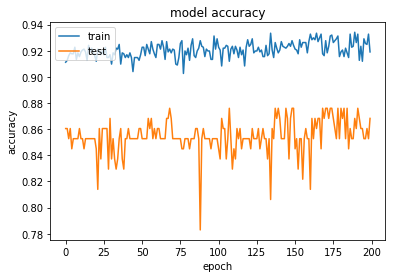

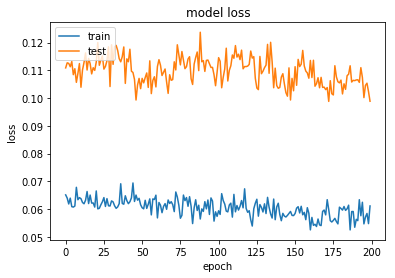

In [44]:
# List all data in history
print(histories[2].history.keys())
# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##### Load pretrained conv model

In [4]:
# load json and create model
json_file = open('trained/conv_model_temp.json', 'r')
conv_model_json = json_file.read()
json_file.close()
model = model_from_json(conv_model_json)
# load weights into new model
model.load_weights("trained/conv_model_quickngood.h5")
print("Loaded model from disk")

Loaded model from disk


##### Additional model evaluation

In [19]:
# This dataset was hand-labeled
x_test, y_test = utils.load_dataset(im_dir="dev_log")

In [11]:
x_val, y_val = x_dev, y_dev
# Evaluate model, get metrics back
stats = model.evaluate(x_val, y_val)
# Calculate predictions vector from model
predictions = model.predict(x_val)
predictions = np.floor(predictions + 0.5)

# Get vector mask for good and bad fits and right and wrong answers
good_fits = y_val
bad_fits = 1 - good_fits
wrong_answers = np.abs(np.subtract(predictions, good_fits))
right_answers = np.subtract(1, wrong_answers)
# Calculate true positives (tp), as well as (tn) (fp) (fn)
true_positives = np.multiply(right_answers, good_fits)
true_negatives = np.multiply(right_answers, bad_fits)
false_positives = np.multiply(wrong_answers, good_fits)
false_negatives = np.multiply(wrong_answers, bad_fits)
# Calculate additional metrics
precision = np.sum(true_positives) / np.sum(true_positives + false_positives)
recall = np.sum(true_positives) / np.sum(true_positives + false_negatives)

# Print stats
print()
print("Performance on VALIDATION set")
print(".............................")
print("Loss: " + str(stats[0]))
print("Accuracy: " + str(stats[1]))
print("Precision: " + str(precision))
print("Recall: " + str(recall))

# Print list of indices of wrong answers
bad_list = []
for i in range(m_dev):
    if wrong_answers[i] == 1:
        bad_list.append(i)
print(".............................")
print("List of indices of wrong guesses:")
print(bad_list)

96/96 [==============================] - 0s 3ms/step

Performance on VALIDATION set
.............................
Loss: 0.12160551299651463
Accuracy: 0.8333333333333334
Precision: 0.9821428571428571
Recall: 0.7857142857142857
.............................
List of indices of wrong guesses:
[5, 13, 16, 22, 42, 48, 52, 53, 65, 77, 78, 79, 83, 86, 93, 95]


##### Look at an image

label: [0]
prediction: [1.]
(236, 348, 3)


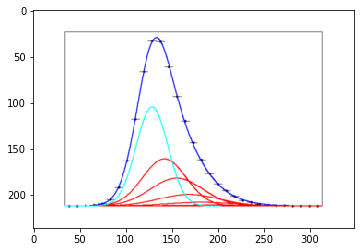

In [14]:
# Choose an index 
index = 52

# Print labels for this index
print("label: " + str(good_fits[index]))
print("prediction: " + str(predictions[index]))

# Show image
this_image = x[index]
print(str(this_image.shape))
plt.imshow(np.uint8(utils.get_printable_image(this_image)))

##### Save convolutional model to disc

In [39]:
#plot_model(simple_model, to_file='simple_model.png')
#SVG(model_to_dot(simple_model).create(prog='dot', format='svg'))

# serialize model to JSON
model_json = model.to_json()
with open("trained/conv_model_temp_160ep.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("trained/conv_model_temp_160ep.h5")
print("Saved model to disk")

Saved model to disk
